In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import os
import ccdproc
from astropy.nddata import CCDData

In [2]:
gain = 1.25*u.electron/u.adu
readnoise = 11.8*u.electron
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

In [3]:
bias_dir = '../project/data/bias'
flats_dir = '../project/data/flats'

listfits = lambda base_dir: [
    os.path.join(base_dir, f) for f in os.listdir(base_dir) if not os.path.isdir(os.path.join(base_dir, f))]

bias_files = listfits(bias_dir)
flat_files = listfits(flats_dir)

In [4]:
bias_list = []
for fname in bias_files:
    data = fits.getdata(fname, ext=0)
    bias_list.append(ccdproc.CCDData(data=data, unit="adu"))
    
flat_list = []
for fname in flat_files:
    data = fits.getdata(fname, ext=0)
    flat_list.append(ccdproc.CCDData(data=data, unit="adu"))

# Bias files

In [26]:
biases = ccdproc.Combiner(bias_list)
master_bias = biases.average_combine()
master_bias_gain_corrected = ccdproc.gain_correct(master_bias, gain)

len(bias_list)

22

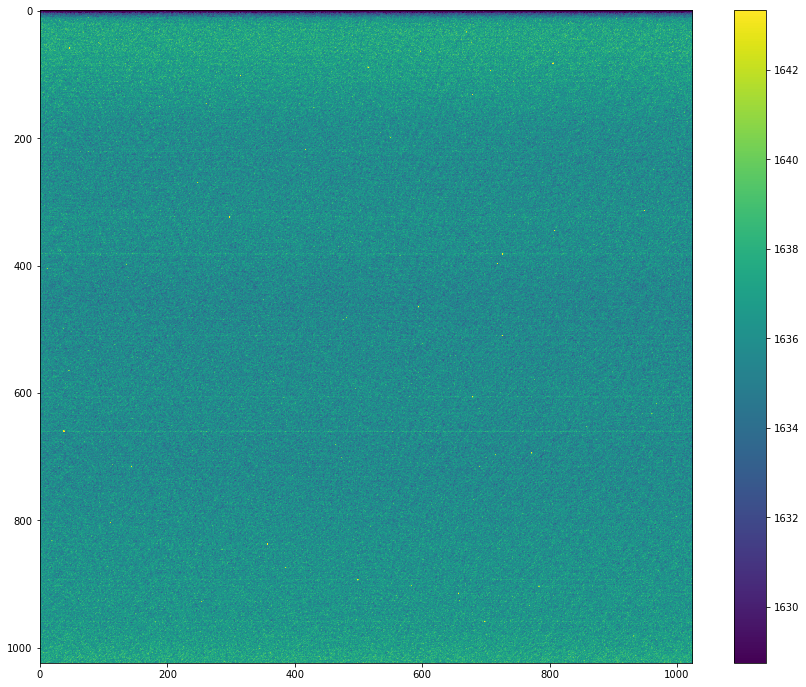

In [86]:
bias_min, bias_max, bias_mean, bias_std = imstats(np.asarray(master_bias_gain_corrected))
plt.figure(figsize=(15, 12))
im = plt.imshow(master_bias_gain_corrected, vmax=bias_mean + 4*bias_std, vmin=bias_mean - 4*bias_std)
plt.colorbar(mappable = im)
plt.savefig('img/bias.png')
plt.show()

In [82]:
["{:.2f}".format(np.mean(b))  for b in bias_list]

print(bias_min, bias_max, bias_mean/ gain, bias_std)

1618.75 1755.625 1308.8889441490173 adu / electron 2.110398447141764


In [8]:
master_bias.write('../project/data/processed/master_bias.fits', overwrite=True)

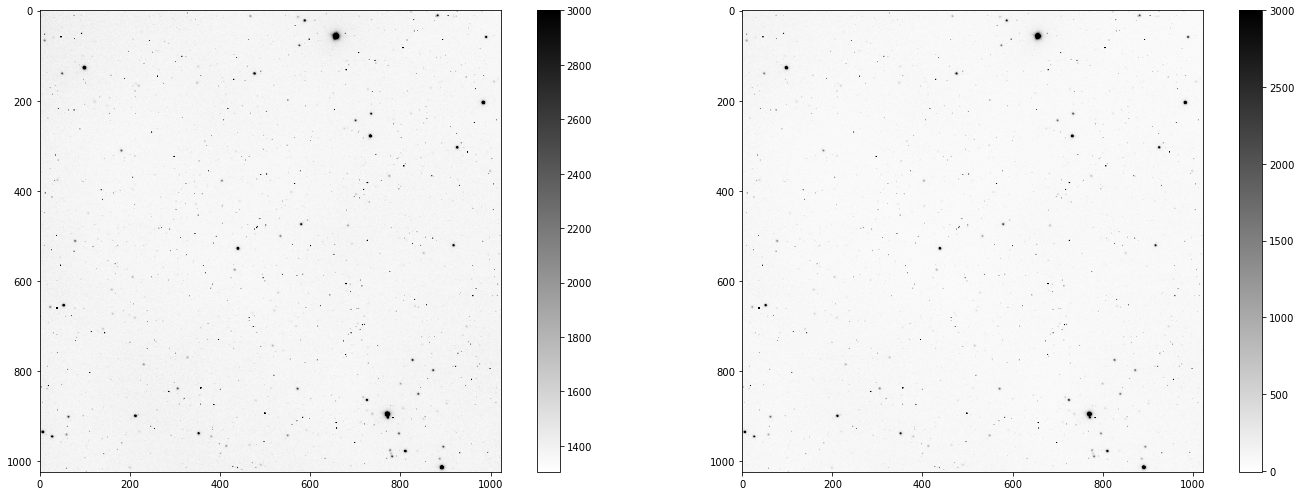

In [176]:
img_proj = fits.getdata('../project/data/J1903+6035_sdss_g_20210513_101141.fits', ext=0)
data_proj = CCDData(img_proj, unit=u.adu)

data_with_deviation = ccdproc.create_deviation(
    data_proj, gain=gain,
    readnoise=readnoise, disregard_nan=True)
data_with_deviation.header['exposure'] = 100.0  # for dark subtraction
gain_corrected = ccdproc.gain_correct(data_with_deviation, gain)
bias_subtracted = ccdproc.subtract_bias(gain_corrected, master_bias_gain_corrected)

cmap = 'binary'
fig = plt.figure(figsize=(20, 7))
plt.subplot(121)
im1 = plt.imshow(data_proj, vmax=3000, cmap=cmap)
fig.colorbar(mappable = im1)
plt.subplot(122)
im2 = plt.imshow(bias_subtracted, vmax=3000, cmap=cmap)

fig.colorbar(mappable = im2)
fig.tight_layout()
plt.savefig('img/bias_subtracted.png')
plt.show()

In [163]:
overscan_file = 'data/wolf1346.0001.f.fits'

header = fits.getheader(overscan_file, ext=0)
{k: header[k] for k in header.keys() if 'SEC' in k}
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2102                                                  
NAXIS2  =                 2050                                                  
OBSERVAT= 'APO'                / Per the IRAF observatory list.                 
TELESCOP= '3.5m'                                                                
INSTRUME= 'arctic'             / Instrument name                                
LATITUDE= +3.2780361000000E+01 / Latitude of telescope base                     
LONGITUD= -1.0582041700000E+02 / Longitude of telescope base                    
TIMESYS = 'TAI'                / Time system for DATE-OBS                       
UTC-TAI = -37.0                / UTC = TAI + UTC_TAI(seconds)                   
UT1-TAI = -36.61            

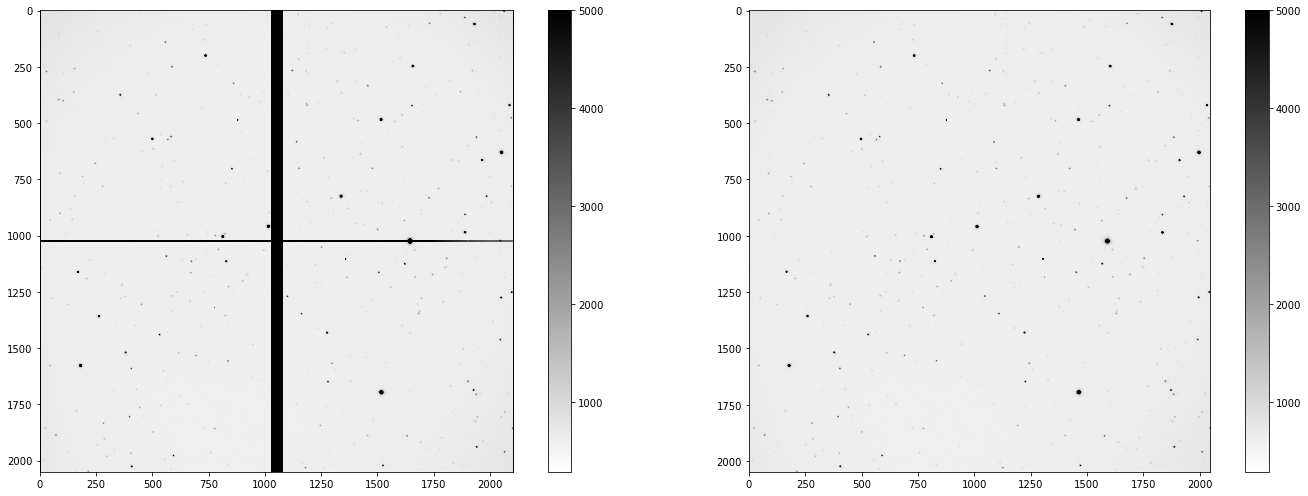

In [150]:
img = fits.getdata(overscan_file, ext=0)
data = CCDData(img, unit=u.adu)

trimmed1 = np.concatenate((ccdproc.trim_image(data, fits_section=header['DSEC11']), 
                          ccdproc.trim_image(data, fits_section=header['DSEC21'])), axis=1)
trimmed2 = np.concatenate((ccdproc.trim_image(data, fits_section=header['DSEC12']), 
                          ccdproc.trim_image(data, fits_section=header['DSEC22'])), axis=1)

trimmed = np.concatenate((trimmed1, trimmed2))
#trimmed = data



fig = plt.figure(figsize=(20, 7))
plt.subplot(121)
im1 = plt.imshow(data, vmax=5000, cmap=cmap)
fig.colorbar(mappable = im1)
plt.subplot(122)
im2 = plt.imshow(trimmed, vmax=5000, cmap=cmap)

fig.colorbar(mappable = im2)
fig.tight_layout()

plt.savefig('img/overscan.png')
plt.show()

# Flat files

In [9]:
def med_over_images(masked_arr, axis=0):
    """
    Calculate median pixel value along specified axis
    
    Uses bottleneck.nanmedian for speed
    """
    
    dat = masked_arr.data.copy()
    dat[masked_arr.mask] = np.NaN
    return np.nanmedian(dat, axis=axis)

def bn_median(masked_array, axis=None):
    """
    Perform fast median on masked array
    
    Parameters
    ----------
    
    masked_array : `numpy.ma.masked_array`
        Array of which to find the median.
    
    axis : int, optional
        Axis along which to perform the median. Default is to find the median of
        the flattened array.
    """
    data = masked_array.filled(fill_value=np.NaN)
    med = np.nanmedian(data, axis=axis)
    # construct a masked array result, setting the mask from any NaN entries
    return np.ma.array(med, mask=np.isnan(med))


flat_combiner = ccdproc.Combiner(flat_list)
flat_combiner.sigma_clipping(func=med_over_images)

# this function will divide each array by its average before combining
# so that each array has an average of 1 after scaling (but before combining)
scaling_func = lambda arr: 1/np.ma.average(arr)
flat_combiner.scaling = scaling_func
master_flat = flat_combiner.median_combine(median_func=bn_median)
master_flat_gain_corrected = ccdproc.gain_correct(master_flat, gain)

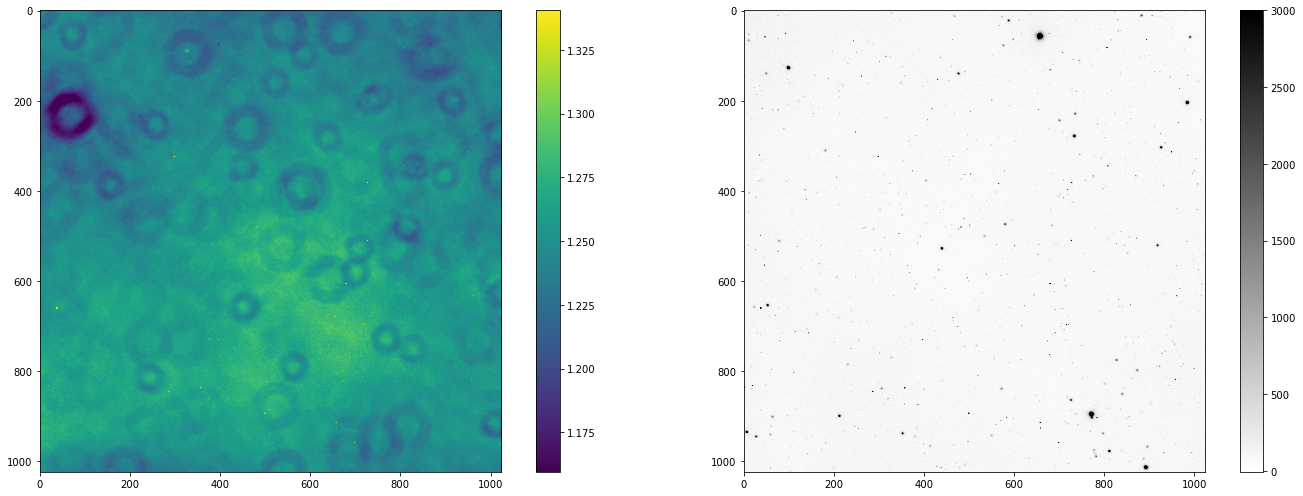

In [181]:
f_min, f_max, f_mean, f_std = imstats(np.asarray(master_flat_gain_corrected))
flat_corrected = ccdproc.flat_correct(bias_subtracted, master_flat_gain_corrected)


fig = plt.figure(figsize=(20, 7))
plt.subplot(121)
im1 = plt.imshow(master_flat_gain_corrected, vmin=f_mean-5*f_std, vmax=f_mean+5*f_std)
plt.colorbar(mappable = im1)
plt.subplot(122)
im2 = plt.imshow(flat_corrected, vmax=3000, cmap=cmap)
fig.colorbar(mappable = im2)
fig.tight_layout()

plt.savefig('img/flat_correction.png')
plt.show()

In [11]:
print(f_min, f_max, f_mean, f_std)

1.1163068965502652 2.428888223791133 1.249994074202755 0.018093422265577235


In [12]:
master_flat_gain_corrected.write('../project/data/processed/master_flat.fits', overwrite=True)

In [167]:
flat_corrected = ccdproc.flat_correct(bias_subtracted, master_flat)

['../project/data/flats\\domeflat_sdss_g_001-2.fits',
 '../project/data/flats\\domeflat_sdss_g_002-2.fits',
 '../project/data/flats\\domeflat_sdss_g_003-2.fits']

# Data analysis

In [610]:
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

mean, median, std = sigma_clipped_stats(flat_corrected, sigma=3.0)  

daofind = DAOStarFinder(fwhm=3.0, threshold=28.*std)  
sources = daofind(flat_corrected - median)  
for col in sources.colnames:
    sources[col].info.format = '%.8g'  # for consistent table output

print(sources)  

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
  1  880.9753 11.366303 0.48407586 ...   0 3193.6299 2.5101374 -0.99924375
  2 586.31519 22.560848 0.47453997 ...   0 4174.6522 3.1606874  -1.2494539
  3 91.558818 51.003221 0.98536228 ...   0  9393.105 7.8464633  -2.2366849
  4 655.20367 55.522942 0.58212974 ...   0 79649.237 44.052192  -4.1099188
  5 652.42824 56.900006 0.68049401 ...   0 80569.941 43.983829  -4.1082326
  6 655.67186 57.140112 0.30354513 ...   0 80819.692 53.728784  -4.3255175
  7 655.48235 56.631148 0.57501625 ...   0 80603.946 42.524086  -4.0715875
  8 988.31382  59.19617 0.46622224 ...   0 3997.3666 3.2994872  -1.2961161
  9 29.389485 59.997015 0.98388022 ...   0 1367.3737 1.1034857 -0.10691677
 10 9.8932919 66.954905 0.55671624 ...   0   1624.53 1.2120599 -0.20881024
...       ...       ...        ... ... ...       ...       ...         ...
 35 769.43189 894.89528 0

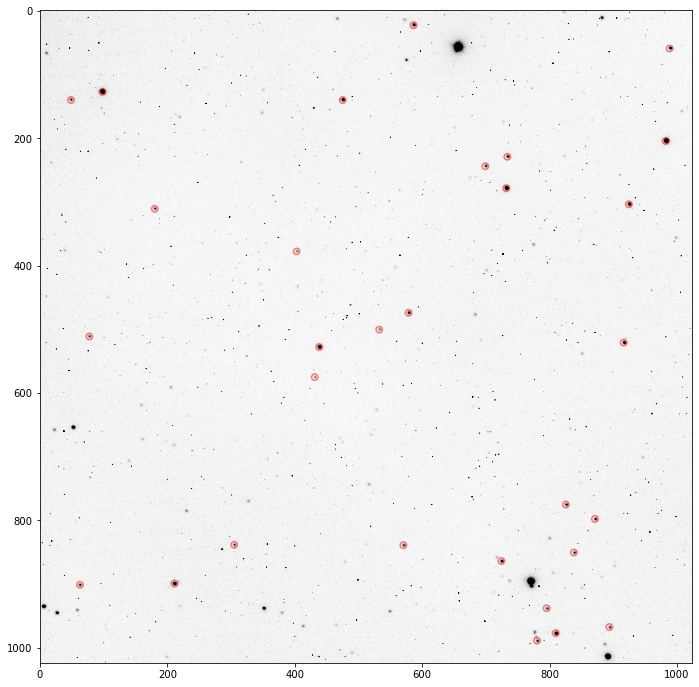

In [611]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
positions = np.delete(positions, [0, 2, 3, 4, 5, 6, 8, 9, 26, 27, 34, 37, 38, 39, 44], axis=0)
apertures = CircularAperture(positions, r=5.)
plt.figure(figsize=(15, 12))
plt.imshow(flat_corrected, cmap=cmap, vmax=2000)
apertures.plot(color='red', lw=1.5, alpha=0.5)

plt.savefig('img/sources.png')
plt.show()

In [612]:
phot_table_exact = aperture_photometry(flat_corrected, apertures, method='exact')
phot_table_center = aperture_photometry(flat_corrected, apertures, method='center')
phot_table_subpixel = aperture_photometry(flat_corrected, apertures, method='subpixel', subpixels=5)

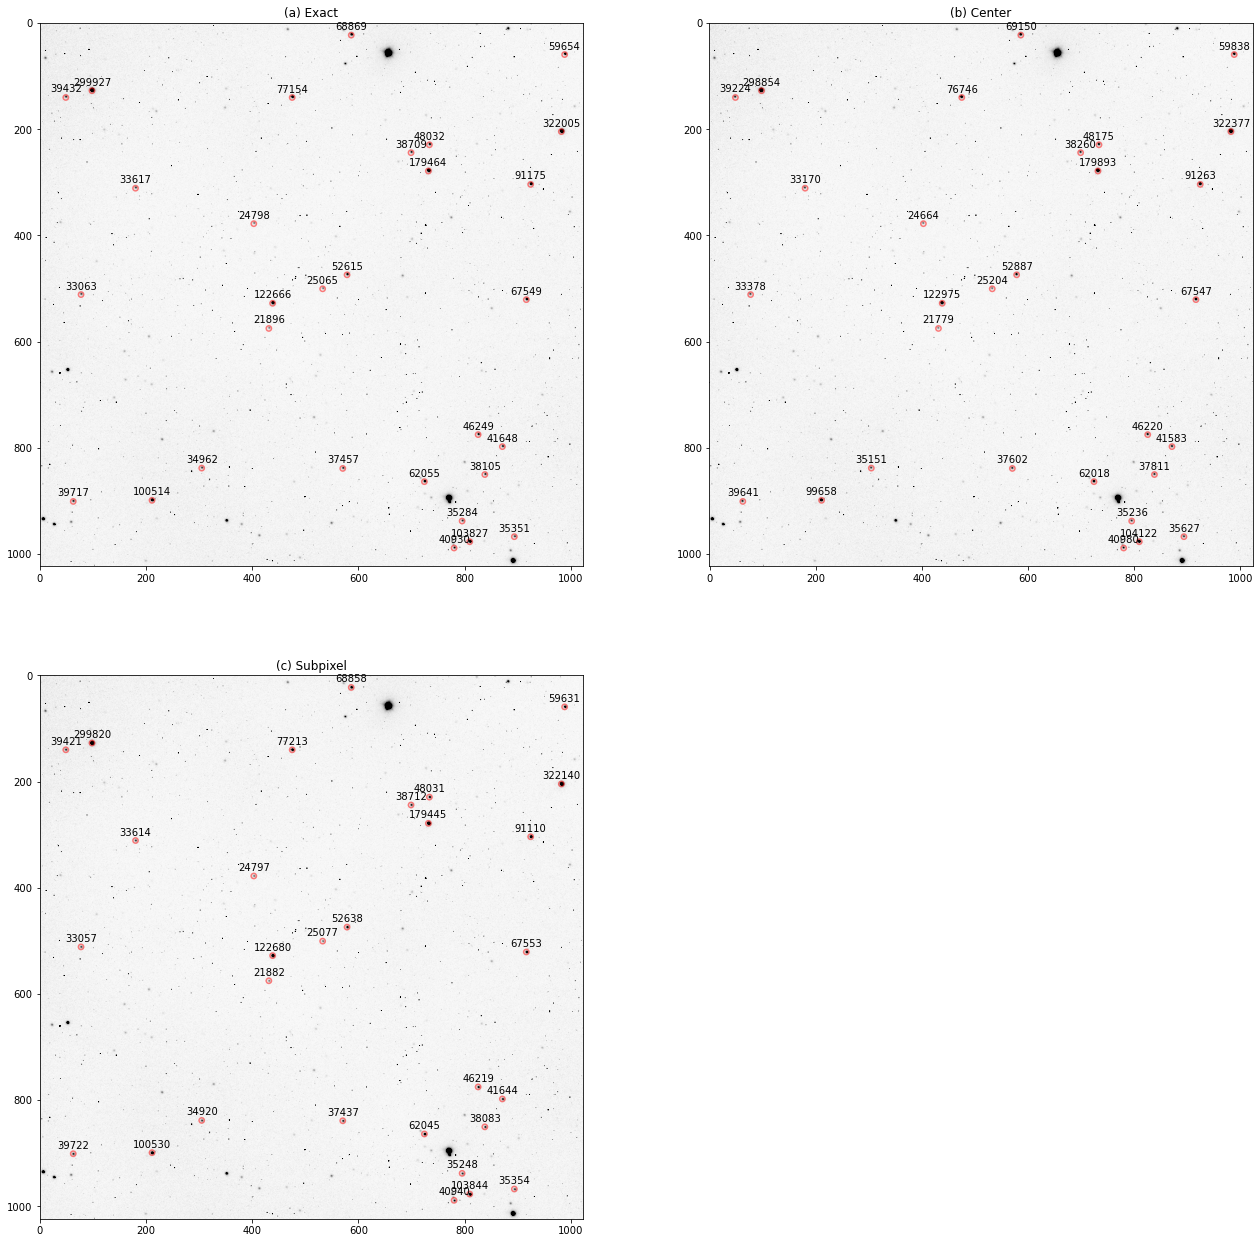

In [613]:
apertures = CircularAperture(positions, r=5.)

plt.figure(figsize=(22, 22))
plt.subplot(221)
plt.title('(a) Exact')
plt.imshow(flat_corrected, cmap=cmap, vmax=2000)
apertures.plot(color='red', lw=1.5, alpha=0.5)
for i, row in phot_table_exact.to_pandas().iterrows():
    c = (row.xcenter, row.ycenter - 10)
    plt.annotate("{:.0f}".format(row.aperture_sum), c,ha='center')

    
plt.subplot(222)
plt.title('(b) Center')
plt.imshow(flat_corrected, cmap=cmap, vmax=2000)
apertures.plot(color='red', lw=1.5, alpha=0.5)
for i, row in phot_table_center.to_pandas().iterrows():
    c = (row.xcenter, row.ycenter - 10)
    plt.annotate("{:.0f}".format(row.aperture_sum), c,ha='center')

plt.subplot(223)
plt.title('(c) Subpixel')
plt.imshow(flat_corrected, cmap=cmap, vmax=2000)
apertures.plot(color='red', lw=1.5, alpha=0.5)
for i, row in phot_table_subpixel.to_pandas().iterrows():
    c = (row.xcenter, row.ycenter - 10)
    plt.annotate("{:.0f}".format(row.aperture_sum), c,ha='center')

fig.tight_layout()
plt.savefig('img/aperture.png')
plt.show()

In [639]:
annuli = CircularAnnulus(positions, 7., 15.)

In [640]:
annulus_aperture_table = aperture_photometry(flat_corrected, annuli, method='exact')

In [641]:
bkg_mean = annulus_aperture_table['aperture_sum'] / annuli.area

In [642]:
bkg_sum = bkg_mean * apertures.area
final_sum = phot_table_exact['aperture_sum'] - bkg_sum
phot_table_exact['residual_aperture_sum'] = final_sum
print(phot_table_exact['residual_aperture_sum'])  

[ 59951.25157679  53678.8583584  287831.07407271  29301.4377582
  68913.19604915 312643.92026683  41353.54794305  32076.79766384
 171500.16914204  82477.65781488  27360.5913543   18972.43289161
  45969.18270729  19209.13965744  25563.46203703  60012.94767629
 116202.70794761  15978.48933123  38770.79892448  34153.02955304
  26371.84313651  30826.14156757  30837.17949881  54177.23143864
  90816.11043765  32089.8807772   27892.46714311  27784.26683847
  95812.49865226  29885.67999972] electron


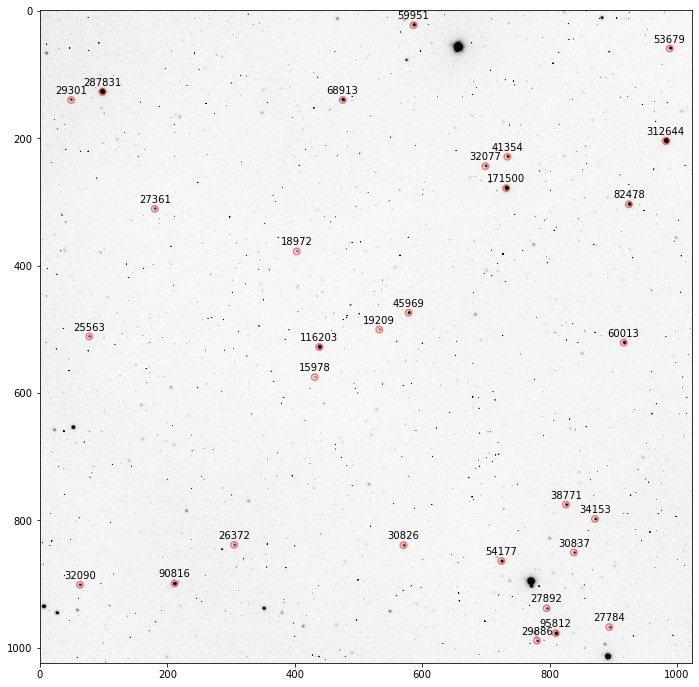

In [710]:
plt.figure(figsize=(12, 12))
plt.imshow(flat_corrected, cmap=cmap, vmax=2000)
apertures.plot(color='red', lw=1.5, alpha=0.5)
for i, row in phot_table_exact.to_pandas().iterrows():
    c = (row.xcenter, row.ycenter - 10)
    plt.annotate("{:.0f}".format(row.residual_aperture_sum), c,ha='center')
    
plt.savefig('img/annulus.png')
plt.show()

In [711]:
from astropy.table import Table
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.psf import (IterativelySubtractedPSFPhotometry,
                           BasicPSFPhotometry)
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import SigmaClip


sigma_psf = 2.0

psf_model = IntegratedGaussianPRF(sigma=sigma_psf)

psf_model.x_0.fixed = True
psf_model.y_0.fixed = True
psf_model.sigma.fixed = False

pos = Table(names=['x_0', 'y_0'], data=[phot_table_exact['xcenter'], phot_table_exact['ycenter']])

In [712]:
daogroup = DAOGroup(crit_separation=8)
sigma_clip = SigmaClip(sigma=3.0)
mmm_bkg = MMMBackground(sigma_clip=sigma_clip)
fitter = LevMarLSQFitter()
photometry = BasicPSFPhotometry(group_maker=daogroup,
                                bkg_estimator=mmm_bkg,
                                psf_model=psf_model,
                                fitter=LevMarLSQFitter(),
                                fitshape=(11,11))
result_tab = photometry(image=flat_corrected, init_guesses=pos)
residual_image = photometry.get_residual_image()

In [713]:
result_tab['diff'] = result_tab['flux_fit'] - np.array(phot_table_exact['residual_aperture_sum'])
result_tab

<Table length=30>
       x_0                y_0         ...         diff       
       pix                pix         ...                    
     float64            float64       ...       float64      
------------------ ------------------ ... -------------------
 586.3151934289671 22.560847805948473 ... -281.84435971397033
 988.3138186208258  59.19616997871415 ... -2261.3304130575634
 97.99626605431057 127.27774249975437 ...   -5939.63408602745
48.681681356250124  140.0375194013334 ...  3225.3714893394717
475.09033763873947 140.07891734503949 ... -1400.5767854131118
 982.0815506374388 204.33408726336728 ... -12751.340529027162
  733.565367729026 229.15036136832387 ... -113.37207066518022
 698.9907806486611 244.02744140331686 ...  -260.5942967972587
 731.6647492773606 278.57441715344856 ...  -6416.858603478788
               ...                ... ...                 ...
 304.6734316250937  838.2006236483003 ...    2003.67819607427
 570.3827801422264  838.8082820401361 ... -124.90336234165443
 838.0047530010577  850.3149590646532 ... -230.50631443675593
 724.1637027158689  863.7304710782058 ...  -258.3181268566623
 211.0512195932122  898.9123911513836 ... -205.48356234371022
 62.65288539030508  900.9362109386198 ...  1244.2773457419826
 795.1994490089253  937.8912252767851 ...    970.393224961852
 893.5802524642488  967.3705867205332 ...   492.8792087857837
 809.4673120707578   976.860324378169 ... -2686.6226210953464
 780.0556902507424  988.7277415885819 ...  3263.4486951684594

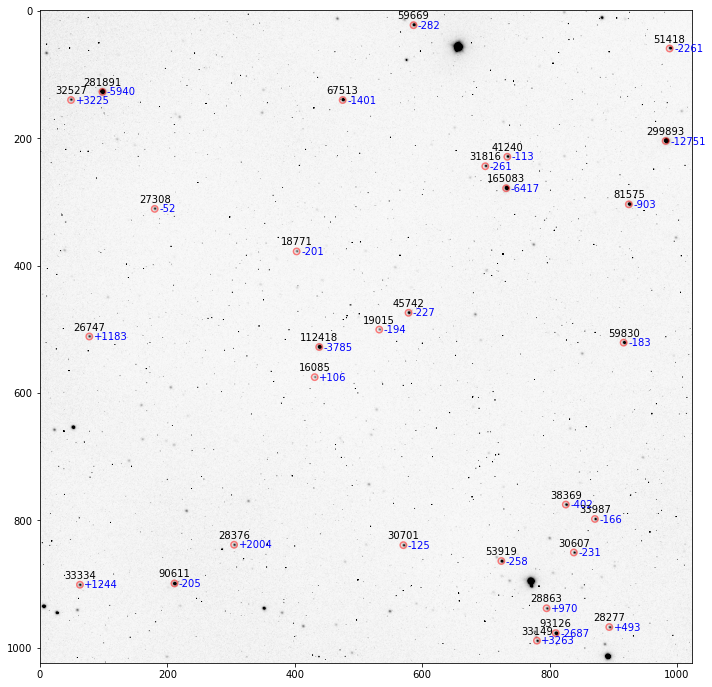

In [714]:
plt.figure(figsize=(12, 12))
plt.imshow(flat_corrected, cmap=cmap, vmax=2000)
apertures.plot(color='red', lw=1.5, alpha=0.5)
for i, row in result_tab.to_pandas().iterrows():
    c = np.array((row.x_0, row.y_0))
    plt.annotate("{:.0f}".format(row.flux_fit), c + (0, -10),ha='center')
    plt.annotate("{:+.0f}".format(row['diff']), c + (7, 5), c='blue')
    
plt.savefig('img/psf_photometry.png')
plt.show()

In [621]:
flat_corrected.write('data/frame.fits', overwrite=True)

In [669]:
annuli.area

552.9203070318035